# Numerical modeling; introduction to Landlab Toolkit

*CU Boulder GEOL 3600/5700 Introduction to Python Programming for Geoscientists, November 2023*

### Goals

- Recognize the basic elements of a forward-time, center-space finite-difference solution to the diffusion equation
- Become familiar with 2D numerical modeling with Landlab

## Revisiting diffusion: a geomorphic example

In a previous class, you had a chance to learn about and experiment with a numerical model of chemical diffusion. Here we'll look at an example in geomorphology, treating the "flow" of soil as a diffusion problem.

### Background: soil creep

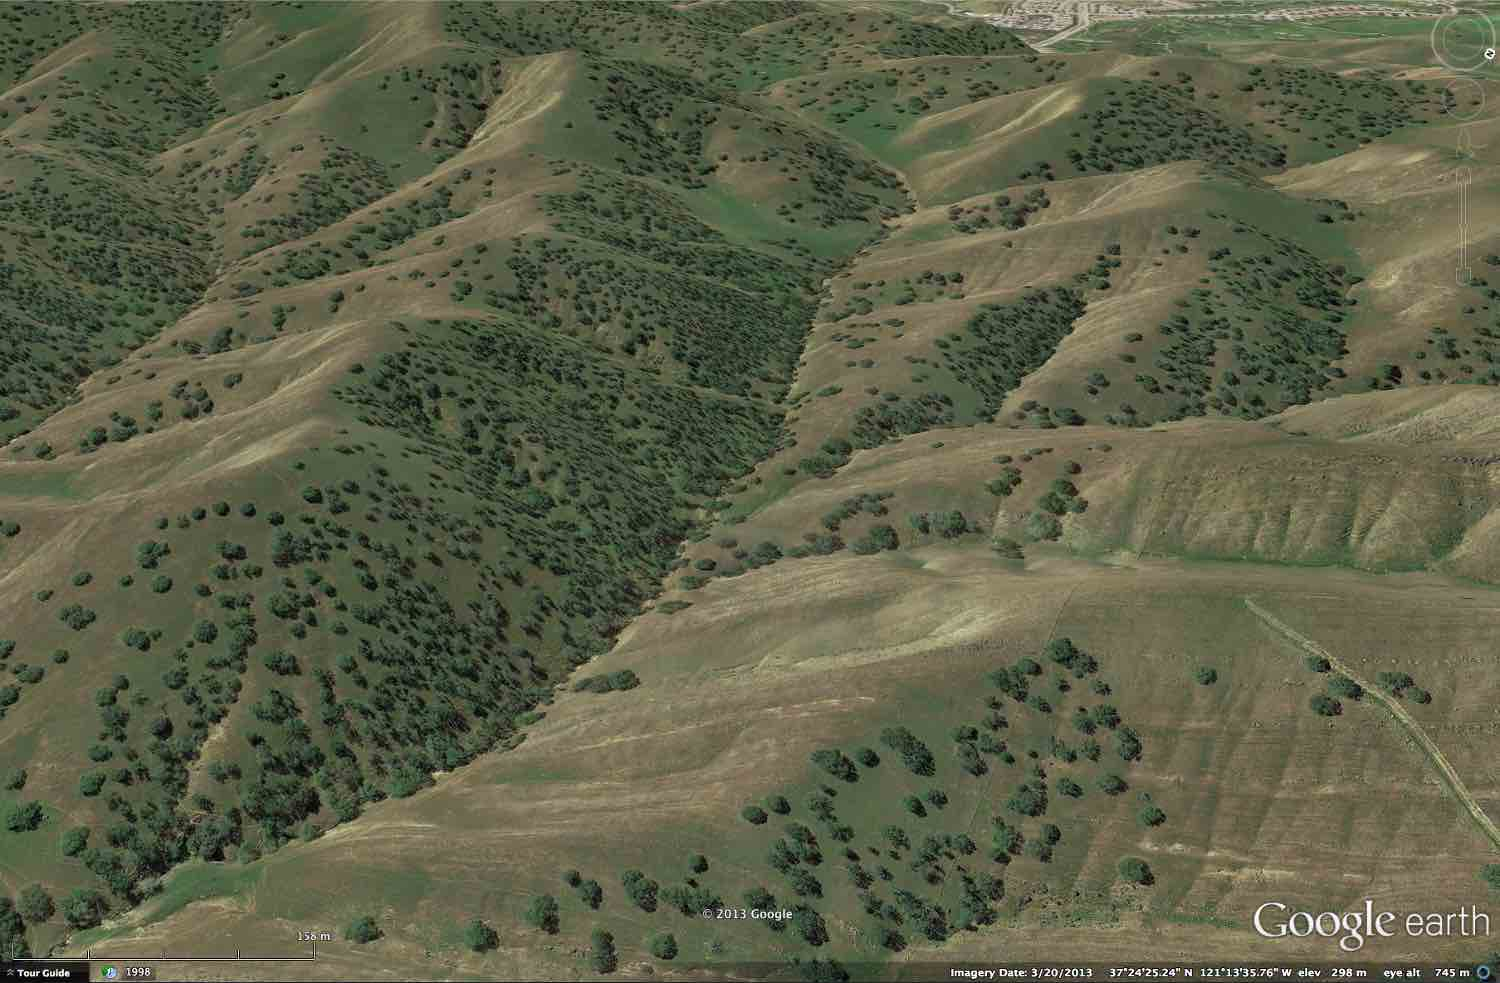

*Soil creep* is the gradual downhill motion of soil by any of a variety of processes, including animal burrowing (animals are more likely to toss soil downhill from their burrows), freeze-thaw cycling (freezing tends to push soil outward, with net motion downhill), the occasional falling of trees with soil attached to their roots (trees are more likely to fall downhill, and take soil with them), among others.

On soil-mantled slopes that aren't too steep, the rate of soil flow downhill, $q$, depends on how steep the hill is. We can write this mathematically as a **flux law** for soil:

$$q = -K_c \frac{\partial z}{\partial x}$$

where $z$ is the height of the land, and $x$ is distance from the hill top. The symbol $q$ represents the volume of soil flow per year per meter in the cross-slope direction. The factor $K_c$ ($c$ for "creep") has units of square meters per year, and has been estimated in the field at anywhere from $10^{-4}$ to $>10^{-2}$, depending on the climate, vegetation, and soil type. The minus sign indicates that soil flows downhill, not uphill.

Where soil creep is the only major process shaping the land, we can also write a mass conservation equation that tells us how fast the land height, $z$, is rising or falling at a given point:

$$\frac{\partial z}{\partial t} = -\frac{\partial q}{\partial x}$$

When you combine these together, here's what you get:

$$\frac{\partial z}{\partial t} = K_c \frac{\partial^2 z}{\partial x^2}$$

This has exactly the form of a 1D diffusion equation!



### Simulating hillslope evolution by soil creep

Suppose we want to model the formation of a ridge between two streams. Each stream is cutting down at a given rate. Our domain consists of a cross-sectional profile from one stream to the other.

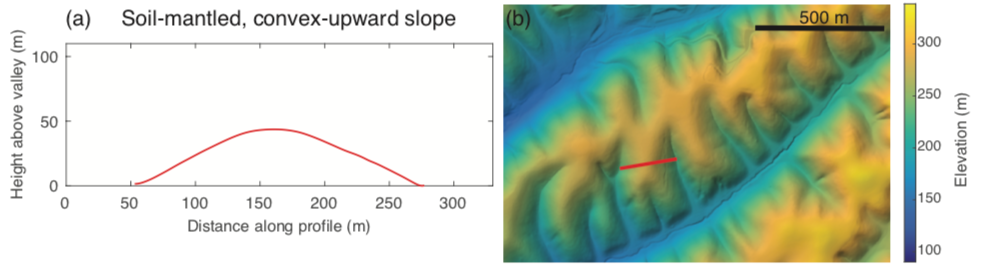



#### Dividing space into finite pieces

To calculate $q$ using a finite-difference approximation, we'll divide hillslope up into discrete pieces, or *cells*. In the middle of each cell is a point, called a *node*, where we'll keep track of $z$. The idea is to update all the values of $z$ at each time step. Here's a sketch that illustrates the basic idea:

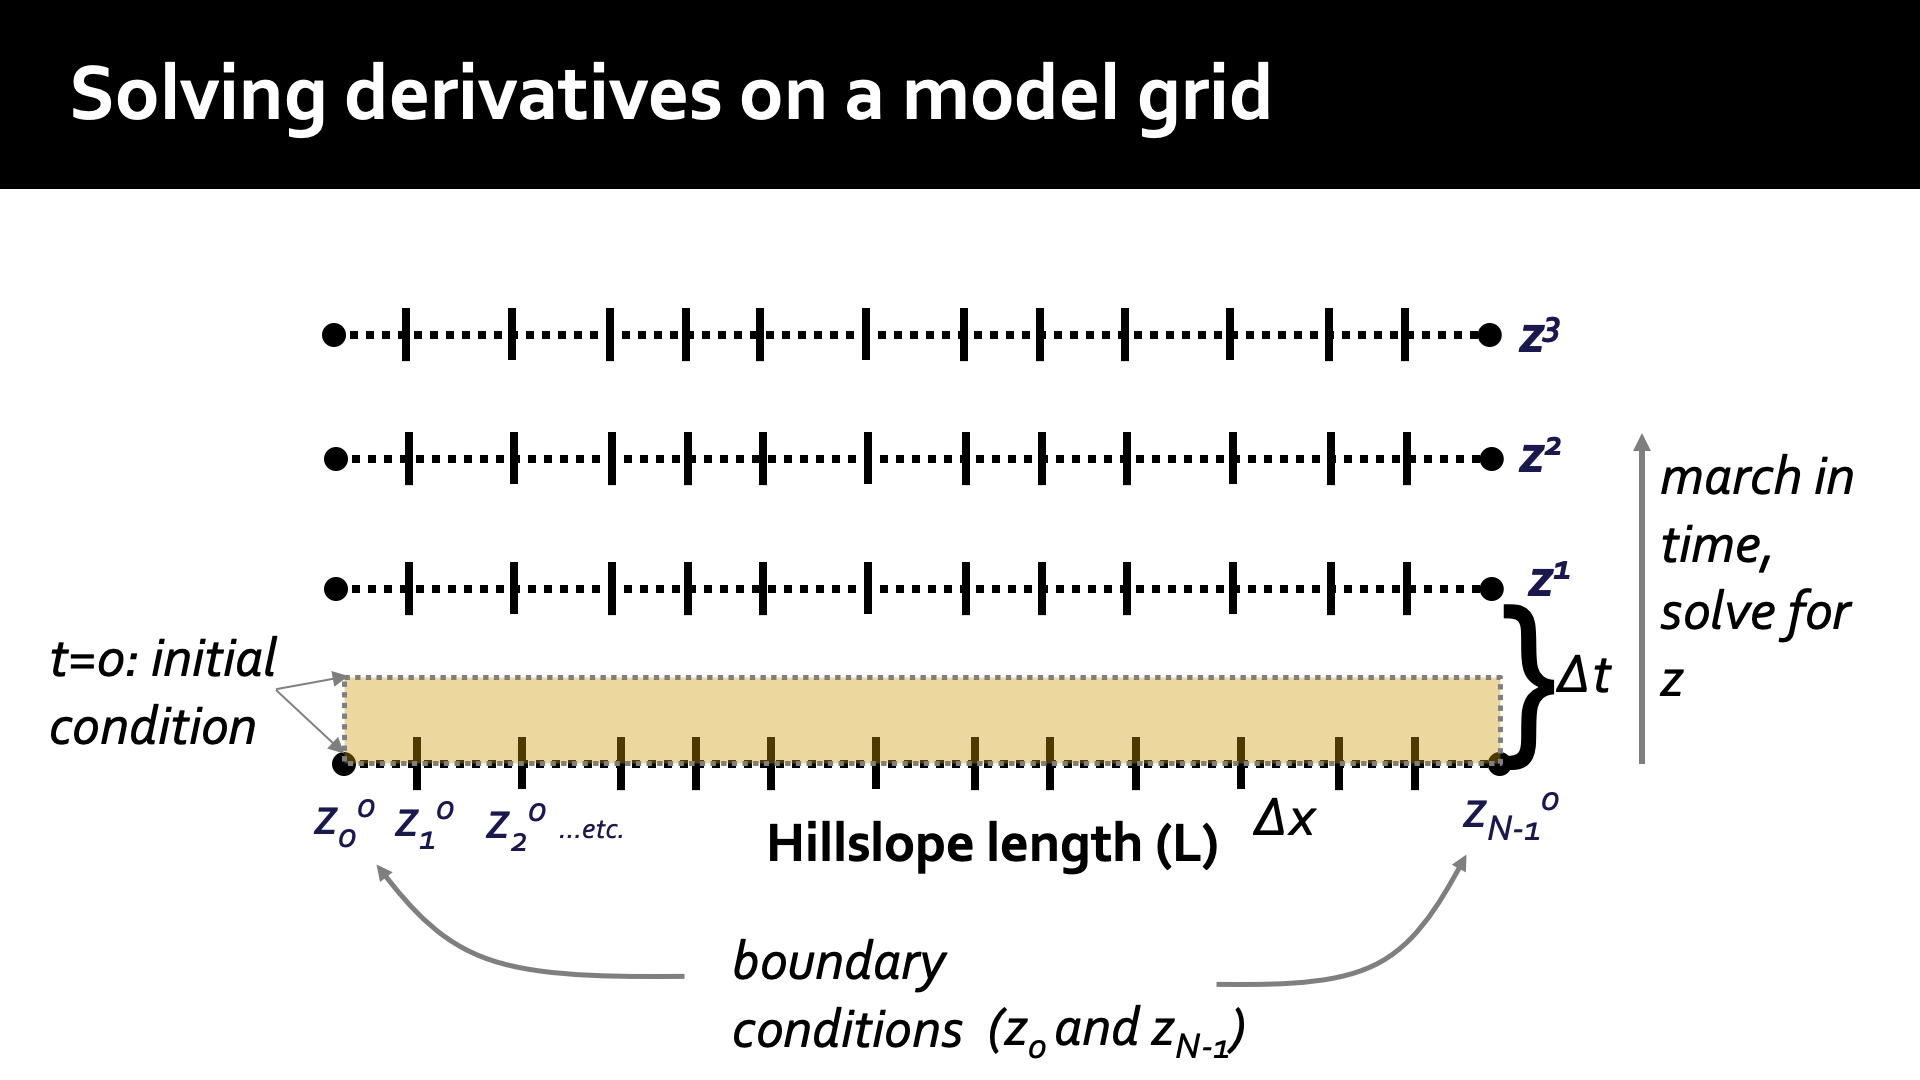



Let's say we have 5 nodes:

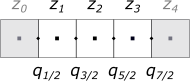

Nodes 0 and 4 are special: they are **boundary nodes**. They represent the heights of the two streams on either side of the ridge. We will make these gradually lower their elevations over time, simulating erosion. We will solve for the hillslope height at nodes 1, 2, and 3.


#### Finite-difference equations

**Notation**: $z_i^t$ means $z$ at node $i$ and time-step $t$.

**Mass conservation**: for node 1, we approximate the mass conservation equation above as:

$$\frac{z_1^{t+1} - z_1^t}{\Delta t} = -\frac{q_{3/2}^t - q_{1/2}^t}{\Delta x}$$

$\Delta t =$ time-step size (in sec), as before

$\Delta x =$ distance between nodes (in meters)

$q_{3/2}^t =$ ...huh?? Three halves? Yes. It's one and a half, and it means the position *halfway between node $1$ and node $2$*. That corresponds to the cell face between those nodes: a natural place to calculate the flux between them. This approach is called a *staggered-grid scheme*.

In general,

$$\frac{z_i^{t+1} - z_i^t}{\Delta t} = -\frac{q_{i+1/2}^t - q_{i-1/2}^t}{\Delta x}$$

Multiply both sides by $\Delta t$, then subtract $z_i^t$ from both sides, and we get an equation that tells us how to calculate the new elevation value at any node:

$$\boxed{z_i^{t+1} = z_i^t-\Delta t\left(\frac{q_{i+1/2}^t - q_{i-1/2}^t}{\Delta x}\right)}$$



**Mass flux:** the finite-difference version of our flux law is:

$$q_{i+1/2}^t = -K_c \left(\frac{z_{i+1}^t - z_i^t}{\Delta x}\right)$$

#### Testing out what we have so far

Let's write some code to set up our hillslope and calculate the fluxes between nodes. We'll represent height $z$ at the 5 nodes using a numpy array. We'll set the initial height to be 0 at the streams, and 1 m everywhere else.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters
Kc = 1.0e-2 # diffusion coefficient, m2/y
dx = 10.0 # distance between nodes, meters

# Create and initialize arrays
x = np.arange(0, dx * 5, dx)
z = np.zeros(5) # hillslope height at the 5 nodes
z[1:4] = 1.0 # initial height at nodes 1, 2, and 3

In [ ]:
# Make a plot of our initial hillslope profile


Calculate the soil flux between nodes 0 and 1. NOTE: a negative flux means the soil is flowing to the left; a positive flux means it's flowing to the right.

In [ ]:
# Calculate and print the flux from node 0 to node 1
q01 = -Kc * (z[1] - z[0]) / dx
print("Soil flux from node 0 to node 1:", q01, " m2/y")

# Try calculating and printing flux for nodes 1 to 2


# ...and nodes 2 to 3


# ...and nodes 3 to 4


#### Questions to ponder

1. Which pairs of nodes have soil flow between them, and which do not? Why?

2. Do the directions of soil flow, indicated by the sign of q, make sense?

It would be convenient if we could calculate all the fluxes at once, and store all the values in an array.

To do this, we'll define an array called `q` that represents the fluxes *at the cell faces between each pair of nodes*. Quiz: how many array elements do we need?

In [ ]:
# Try it out: make a numpy array to hold the flux values


To calculate values for `q`, we want to take the *difference* in `z` at each adjacent pair of nodes. An easy way to do this is using the numpy `diff()` function.

In [ ]:
thing = np.array([8, 2, 3, 5])
np.diff(thing)

In [ ]:
# Example of diff()
diff_z = np.diff(z)
print(diff_z)

**Try it yourself**: use `diff` to calculate values for flux at each node pair, by multiplying the difference by `-D` and dividing by the distance between nodes, `dx`:

In [ ]:
# (your code here)


### Applying mass conservation

Let's go back to mass conservation. Previously we found a formula for updating elevation at any node for a new time step:

$$\boxed{z_i^{t+1} = z_i^t-\Delta t\left(\frac{q_{i+1/2}^t - q_{i-1/2}^t}{\Delta x}\right)}$$

We know how to calculate $q$. How can we use numpy to calculate the piece in parentheses?

In [ ]:
# Recipe:
# - calculate the values of q at the cell edges
# - use np.diff() to calculate the difference in each pair of q
# - divide by node spacing (dx)
# - store the result in an array variable called dqdx
q = -Kc * np.diff(z) / dx # flux at the 4 cell edges
dqdx = np.diff(q) / dx # "divergence" of flux at 3 inner nodes

# Report the results
print("Fluxes at cell edges:", q)
print("Difference in q divided by dx:", dqdx)

### *Making sense of array sizes*

- $z$ has 5 elements, representing the 5 nodes.
- $q$ has 4 elements, representing the 4 cell faces between nodes
- $dqdx$ has 3 elements, representing the 3 interior nodes

```
.--|--o--|--o--|--o--|--.
0     1     2     3     4  <= z at 5 nodes
   0     1     2     3     <= q at 4 cell edges
      0     1     2        <= dqdx at 3 interior nodes
```

### *Updating $z$ for one time step*

We've now seen how to calculate the quantity in parenthese below:

$$z_i^{t+1} = z_i^t - \Delta t \left(\frac{q_{i+1/2}^t - q_{i-1/2}^t}{\Delta x}\right)$$

In our code, to update values of `z` for the new time step, we multiply `dqdx`by time-step size and subtract it from the current values of `z`. But we **only** do this for the interior values of `z`, which we can access like this:


In [ ]:
# Define a value for time-step size
dt = 1000.0 # time-step duration, years

# Calculate new values for height of the interior nodes (i.e., nodes 1, 2, and 3)
z[1:4] -= dt * dqdx
print("New values of z:", z)

# Try plotting this


#### Lowering the streams

To have the streams erode, we need to lower the elevations of nodes 0 and 4 by some amount each time step. Here's one way to approach this:

```
lowering_rate = 0.001 # stream lowering rate in m/y
drop_per_step = lowering_rate * dt # vertical lowering of streams each time step

...(OTHER PARAMETERS SET UP HERE)...

for i in range(num_time_steps):
    z[0] -= drop_per_step
    z[-1] -= drop_per_step
    ...(OTHER STEPS IN LOOP HERE)...
```

### *Pseudocode for the solution algorithm*

**Pseudocode** *is a shorthand way of writing an algorithm without using the precise syntax of a specific programming language. It's *really* helpful to write down pseudocode before you translate your algorithm into actual Python code (or any other programming language).*

We've seen each individual piece. Now we'll write out the complete solution algorithm, first using *pseudocode*:

```
# Initialize
Define parameters
Set up arrays

# Run
FOR each time step DO
    Lower the elevation at the two stream nodes
    Calculate flux values at cell faces
    Calculate divergence (dqdx) at interior nodes
    Update z values for the new time step

# Finalize
Plot and/or report final values
```

### <div style="color:green">In-class practice</div>

Write a program that translates the above pseudocode into actual code!

In [ ]:
# (your code here)

## Going 2D with help from Landlab Toolkit

### What is Landlab?

As we saw in an earlier presentation, [Landlab](https://landlab.github.io) is a Python package designed to make it easier to build grid-based numerical models. Among other things, Landlab provides:

1. **Grid objects** that contain data and methods to manage a 2D grid
2. **Fields:** arrays of data that can be added to grid elements
3. **Components:** Python classes that implement one particular process or function
3. **Utilities:** various helpful functions to making calculations, reading input, and writing output

### Making a grid

Here we'll make a small `RasterModelGrid` and play with it.
```
from landlab import RasterModelGrid

nrows = 5 # number of node rows
ncols = 4 # number of node columns
dx = 10.0 # spacing between nodes

# Instantiate a new RasterModelGrid object
grid = RasterModelGrid((nrows, ncols), dx)

# Report the number of nodes
print(grid.number_of_nodes)

# Plot the node positions
plt.scatter(grid.x_of_node, grid.y_of_node)
```

In [ ]:
from landlab import RasterModelGrid

nrows = 5 # number of node rows
ncols = 4 # number of node columns
dx = 10.0 # spacing between nodes

# Instantiate a new RasterModelGrid object
grid = RasterModelGrid((nrows, ncols), dx)

# Report the number of nodes
print(grid.number_of_nodes)

# Plot the node positions
plt.scatter(grid.x_of_node, grid.y_of_node)

### Inspecting grid elements with **grid sketchbook**

The online **[grid sketchbook](https://landlab.github.io/grid-sketchbook)** helps visualize the different elements of a Landlab grid.

Go to https://landlab.github.io/grid-sketchbook and create a Raster grid with 4 rows and 5 columns.

Notice the six element types: nodes, links, patches, corners, faces, and cells.

#### Questions

1. Which link connects nodes 6 and 7?
2. Which node is inside of cell 4?
3. Which cell contains node 8?
4. Which node does link 14 point to?


## A 2D diffusion model in Landlab

The following demonstrates how we can use a Landlab grid to implement our earlier hillslope simulation, but this time in 2D instead of 1D. The point here is to give you a first glimpse at how you can code up a finite-difference model using a Landlab grid.

In [ ]:
# Make a grid
grid = RasterModelGrid((16, 10), 10.0)

# Make an array to hold the elevation values, initially at 100 m
z = np.zeros(grid.number_of_nodes) + 100.0 # one elevation value per grid node

# Parameters
num_steps = 20 # number of time steps
dt = 1000.0 # size of a time step in years
lowering_rate = 0.001 # lowering rate of boundaries, m/y
drop_per_step = lowering_rate * dt # elevation drop of grid edges each time step, in meters
Kc = 0.01 # creep coefficient, m2/y

# Time loop
for _ in range(num_steps):

    # lower the boundary nodes
    z[grid.perimeter_nodes] -= drop_per_step

    # calculate gradients at links (Landlab's 2D version of "diff(z) / dx"!)
    grad = grid.calc_grad_at_link(z) 

    # calculate soil flux at each link
    q = -Kc * grad

    # calculate ins and outs of soil in each cell (2D version of "diff(q) / dx")
    dqdx = grid.calc_flux_div_at_node(q) 

    # update elevations
    z[grid.core_nodes] -= dqdx[grid.core_nodes] * dt 

Now let's make a surface plot of the resulting landform.

(Note: Landlab arrays are 1D, but the matplotlib `plot_surface()` function wants 2D arrays, so we have to reshape them before plotting.)

In [ ]:
# "turn on" 3D plotting
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# plot_surface() wants 2d arrays, so we have to reshape our Landlab arrays
nrows = grid.number_of_node_rows
ncols = grid.number_of_node_columns
x2d = grid.x_of_node.reshape((nrows, ncols))
y2d = grid.y_of_node.reshape((nrows, ncols))
z2d = z.reshape((nrows, ncols))

# make a surface plot
ax.plot_surface(x2d, y2d, z2d)
ax.set_xlabel('East-west distance (m)')
ax.set_ylabel('North-south distance (m)')
ax.set_zlabel('Elevation (m)')

### <div style="color:green">Optional: playing with the model</div>

Experiment with your model.

1. What happens if you run it longer? Does the height of the hill (relative to the base) keep rising, or does it reach a steady state?

2. What happens if you increase the creep coefficient by 4x? (e.g., wetter climate)

3. What happens if you lower the creep coefficient by 4x? (e.g., drier climate)

4. What happens if you increase the lowering rate?

5. What happens if you reduce the lowering rate?

6. What happens if you make the model domain (i.e., the size of the hill) bigger or smaller?

### *Optional: advanced challenge problems*

If the finite-difference diffusion solution seems straightforward, try the following:

1. Combine the two finite-difference equations for 1D diffusion together to show that

$$z_i^{t+1} = z_i^t + \frac{K_c\Delta t}{\Delta x^2} \left(z_{i+1}^t - 2 z_i^t + z_{i-1}^t \right)$$

2. Write a program that implements this solution directly. Hint: think about what the following numpy array operation does:

```
z[2:] - 2 * z[1:-1] + z[:-2]
```

3. Modify your program so that the $K_c$, $\Delta t$, and $\Delta x^2$ are combined in a single variable called `alpha`. Experiment with different values of this parameter. What does your calculation look like when `alpha = 0.2`? When `alpha = 1`? Look back to how we calculated time-step size in Notebook 17.

4. In the Landlab-based 2D model, try making `Kc` vary in space. (Hint: you'll need to make `Kc` an array, with one value per grid link.)